In [20]:
from fastai import *
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42)

In [3]:
base_path = Path("/kaggle/input/d/spikeybarbs/dsc-logika-ui-2025")
base_path.ls()

(#3) [Path('/kaggle/input/d/spikeybarbs/dsc-logika-ui-2025/sample_submission.csv'),Path('/kaggle/input/d/spikeybarbs/dsc-logika-ui-2025/Test'),Path('/kaggle/input/d/spikeybarbs/dsc-logika-ui-2025/Train')]

In [4]:
train_path = base_path/'Train'/'Train'
test_path = base_path/'Test'/'Test'

In [5]:
item_tfms = RandomResizedCrop(224, min_scale=0.5)
batch_tfms = aug_transforms()

dls = ImageDataLoaders.from_folder(
    train_path,
    valid_pct=0.2,
    seed = 42,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
    num_workers=4
)

Contoh data training/validasi:
Classes: ['balinese', 'batak', 'dayak', 'javanese', 'minangkabau']
Number of classes: 5
Number of training images: 1402
Number of validation images: 350


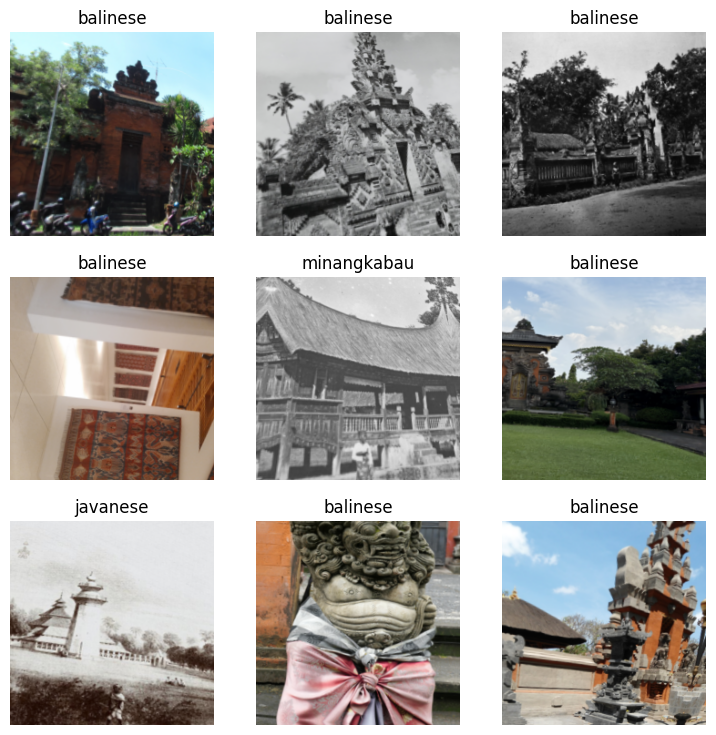

In [6]:
print("Contoh data training/validasi:")
dls.show_batch(max_n=9)

test_files = get_image_files(test_path)
test_dl = dls.test_dl(test_files)

print("Classes:", dls.vocab)
print("Number of classes:", len(dls.vocab))
print("Number of training images:", len(dls.train_ds))
print("Number of validation images:", len(dls.valid_ds))

In [21]:
learn = vision_learner(dls, resnet50,
                       metrics=[accuracy, F1Score(average='macro')],
                       path='/kaggle/working/').to_fp16()

SuggestedLRs(valley=0.0010000000474974513)

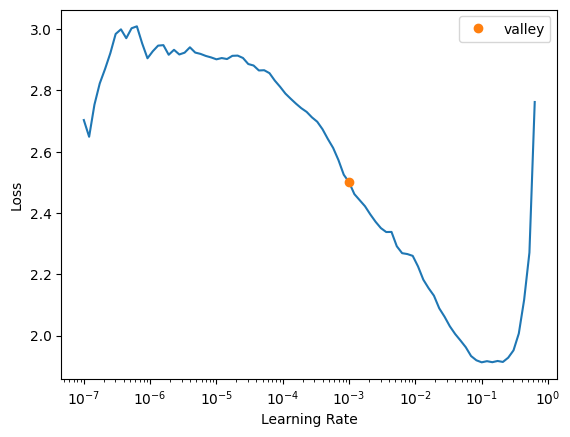

In [8]:
learn.lr_find()

In [9]:
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(50,slice(lr1,lr2))

epoch,train_loss,valid_loss,accuracy,time
0,1.979224,1.104756,0.694286,02:39
1,1.331365,0.881071,0.720000,02:33
2,1.052941,0.966006,0.708571,02:36
3,0.914322,1.124925,0.745714,02:36
4,0.916114,1.411414,0.728571,02:34
5,1.082912,1.822620,0.657143,02:41
6,1.129709,1.449037,0.671429,02:41
7,1.107100,1.647905,0.654286,02:34
8,1.064154,0.996020,0.720000,02:36
9,1.023839,1.968340,0.611429,02:36


In [10]:
learn.unfreeze()
learn.fit_one_cycle(25,slice(1e-4,1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.195634,1.096932,0.782857,02:36
1,0.232877,1.183033,0.771429,02:37
2,0.248538,1.032061,0.800000,02:39
3,0.223436,0.939815,0.814286,02:36
4,0.198546,0.893301,0.820000,02:36


In [11]:
learn.recorder

Recorder

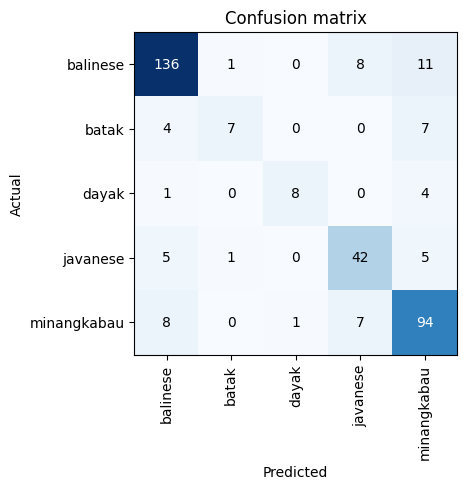

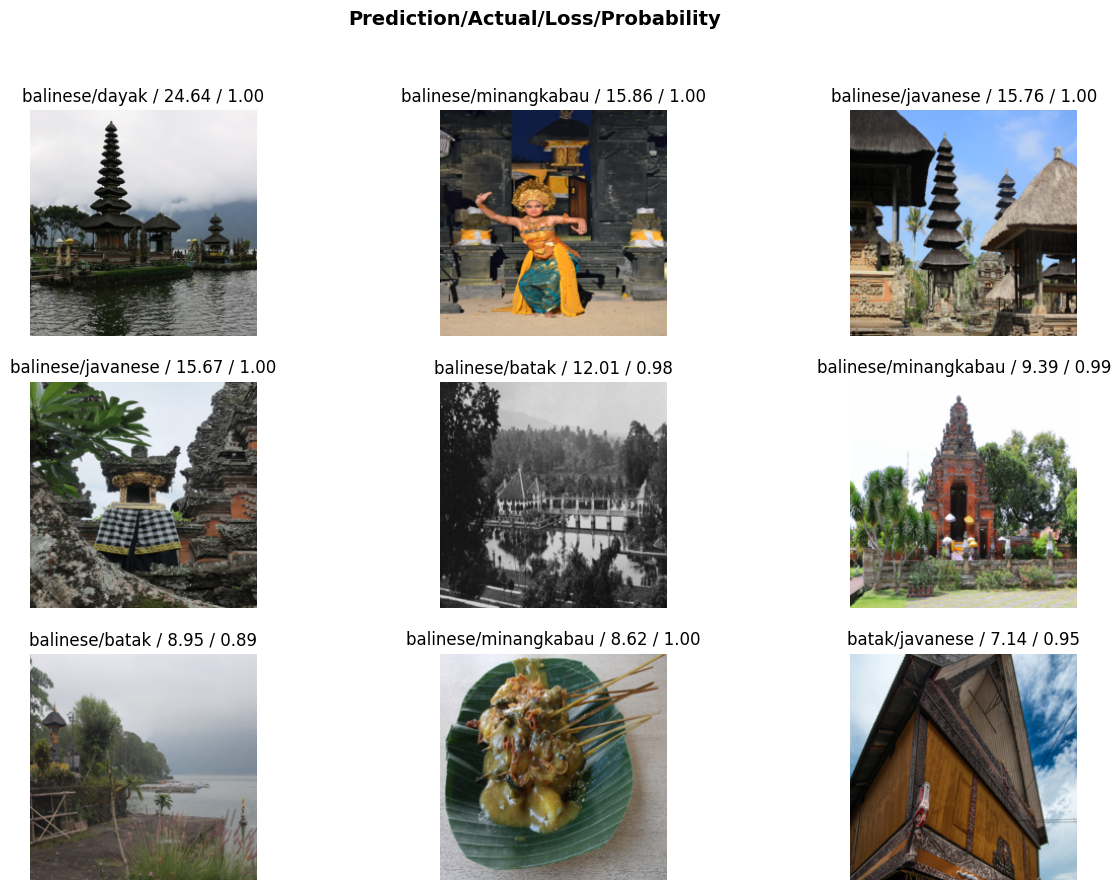

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(9, figsize=(15,10))

In [19]:
interp.print_classification_report()

              precision    recall  f1-score   support

    balinese       0.88      0.87      0.88       156
       batak       0.78      0.39      0.52        18
       dayak       0.89      0.62      0.73        13
    javanese       0.74      0.79      0.76        53
 minangkabau       0.78      0.85      0.81       110

    accuracy                           0.82       350
   macro avg       0.81      0.70      0.74       350
weighted avg       0.82      0.82      0.82       350



In [14]:
test_files = get_image_files(test_path)

preds, _ = learn.get_preds(dl=dls.test_dl(test_files))
pred_labels = preds.argmax(dim=1)
label_names = [dls.vocab[i] for i in pred_labels]

In [15]:
# Prepare submission DataFrame with correct columns: 'id' and 'style'
submission = pd.DataFrame({
    'id': [f.name[:-4] for f in test_files],
    'style': label_names
})

# Ensure the order matches sample_submission.csv if needed
sample_sub_path = train_path/'sample_submission.csv'
if sample_sub_path.exists():
    sample_sub = pd.read_csv(sample_sub_path)
    submission = submission.set_index('id').loc[sample_sub['id']].reset_index()

In [16]:
submission.sort_values('id', inplace = True)

In [17]:
# Save to CSV
submission.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")

Submission file saved as submission.csv
